Especialização em Ciência dos Dados – Redes Neurais Artificiais (Aprendizado Profundo/Deep Learning)

1º Desafio em RNA/Deep Learning

Aluna: Cristiane Gea

In [ ]:
# ==========================
# IMPORTAÇÕES E LEITURA BASE
# ==========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import warnings
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [ ]:
# =================
# LEITURA DOS DADOS
# =================

df = pd.read_excel("funcao.xlsx")
df_xy = df[['x','y']].dropna().copy()
X = df_xy[['x']].values.astype(float)
y = df_xy['y'].values.astype(float)

# Extrair curva alvo (linha vermelha = ymean em função de xgrd)
if 'xgrd' in df.columns and 'ymean' in df.columns:
    grd = df[['xgrd','ymean']].dropna().drop_duplicates().sort_values('xgrd')
    xgrd = grd['xgrd'].values.reshape(-1,1)
    ymean = grd['ymean'].values
else:
    # fallback se não houver ymean explícito
    xgrd = np.linspace(X.min(), X.max(), 201).reshape(-1,1)
    from sklearn.gaussian_process import GaussianProcessRegressor
    gp = GaussianProcessRegressor().fit(X, y)
    ymean = gp.predict(xgrd)

In [ ]:
# ================
# PREPROCESSAMENTO
# ================

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

sc_X = StandardScaler()
Xs_train = sc_X.fit_transform(X_train)
Xs_val = sc_X.transform(X_val)
xgrd_s = sc_X.transform(xgrd.reshape(-1, X_train.shape[1]))

sc_y = StandardScaler()
ys_train = sc_y.fit_transform(y_train.reshape(-1,1)).ravel()
ys_val = sc_y.transform(y_val.reshape(-1,1)).ravel()

In [ ]:
# ==================================
# FUNÇÃO PARA CRIAR MODELO NO KERAS
# ==================================

def build_mlp_keras(input_dim, hidden_size=16, activation='relu', lr=0.001):
    model = Sequential()
    model.add(Dense(hidden_size, input_dim=input_dim, activation=activation))
    model.add(Dense(1, activation='linear'))  # saída contínua
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

In [ ]:
# ======================================
# FUNÇÕES DE ESCOLHA DE TOPOLOGIA MÍNIMA
# ======================================

def choose_minimal_by_tolerance(results, tol=0.05):
    means = np.array([r['rmse_val_mean'] for r in results])
    best = means.min()
    acceptable = best * (1 + tol)
    for r in sorted(results, key=lambda x: x['hidden']):
        if r['rmse_val_mean'] <= acceptable:
            return r, best, acceptable
    best_idx = np.argmin(means)
    return results[best_idx], best, acceptable

def choose_minimal_by_elbow(results, improvement_tol=0.01):
    sorted_res = sorted(results, key=lambda x: x['hidden'])
    means = np.array([r['rmse_val_mean'] for r in sorted_res])
    prev = means[0]
    for i in range(1, len(means)):
        improvement = prev - means[i]
        if improvement < improvement_tol:
            return sorted_res[max(0, i-1)], means.min(), improvement
        prev = means[i]
    best_idx = np.argmin(means)
    return sorted_res[best_idx], means.min(), 0.0

In [ ]:
# ====================================
# CONFIGURAÇÕES E LOOP DE EXPERIMENTOS
# ====================================

hidden_candidates = [2,4,8,16,32,64]  # exemplo
epochs_list = [200, 1000]
n_repeats = 5
activations = {'ReLU':'relu', 'tanh':'tanh', 'sigmoid':'sigmoid'}

results = []

for act_name, act_val in tqdm(activations.items(), desc="Ativações"):
    for hs in tqdm(hidden_candidates, desc="Hidden neurons", leave=False):
        for epochs in tqdm(epochs_list, desc="Epochs", leave=False):
            preds_on_grid = []
            rmses_val = []
            for rep in tqdm(range(n_repeats), desc="Repetições", leave=False):
                seed = 42 + rep
                tf.random.set_seed(seed)
                np.random.seed(seed)

                model = build_mlp_keras(input_dim=Xs_train.shape[1],
                                        hidden_size=hs,
                                        activation=act_val,
                                        lr=0.001)

                model.fit(Xs_train, ys_train, epochs=epochs,
                          verbose=0, batch_size=len(Xs_train))

                # Avaliação no conjunto de validação
                pred_val = model.predict(Xs_val).ravel()
                rmse_val = np.sqrt(mean_squared_error(y_val, sc_y.inverse_transform(pred_val.reshape(-1,1)).ravel()))
                rmses_val.append(rmse_val)

                # Predição na grade
                pred_grid = model.predict(xgrd_s).ravel()
                pred_grid = sc_y.inverse_transform(pred_grid.reshape(-1,1)).ravel()
                preds_on_grid.append(pred_grid)

            results.append({
                'activation': act_name,
                'hidden': hs,
                'epochs': epochs,
                'preds_grid': np.array(preds_on_grid),
                'rmse_val_mean': np.mean(rmses_val),
                'rmse_val_std': np.std(rmses_val)
            })

Hidden neurons:   0%|          | 0/6 [00:00<?, ?it/s]

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  20%|██        | 1/5 [00:12<00:51, 12.90s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  40%|████      | 2/5 [00:25<00:37, 12.43s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  60%|██████    | 3/5 [00:37<00:24, 12.47s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  80%|████████  | 4/5 [00:50<00:12, 12.63s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições: 100%|██████████| 5/5 [01:02<00:00, 12.55s/it]


                                                         


                                                         



Epochs:  50%|█████     | 1/2 [01:02<01:02, 62.83s/it]





Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 








Repetições:  20%|██        | 1/5 [00:59<03:56, 59.24s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 








Repetições:  40%|████      | 2/5 [01:56<02:54, 58.18s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  60%|██████    | 3/5 [02:53<01:55, 57.65s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  80%|████████  | 4/5 [03:52<00:57, 57.98s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições: 100%|██████████| 5/5 [04:48<00:00, 57.26s/it]





                                                         

                                                         

                                                      


Epochs: 100%|██████████| 2/2 [05:51<00:00, 195.38s/it]

                                                      

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]


Hidden neurons:  17%|█▋        | 1/6 [05:51<29:15, 351.01s/it]

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  20%|██        | 1/5 [00:12<00:49, 12.38s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  40%|████      | 2/5 [00:24<00:37, 12.50s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  60%|██████    | 3/5 [00:37<00:25, 12.52s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  80%|████████  | 4/5 [00:49<00:12, 12.50s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições: 100%|██████████| 5/5 [01:02<00:00, 12.41s/it]





                                                         

Epochs:  50%|█████     | 1/2 [01:02<01:02, 62.23s/it]


                                                         

Epochs:  50%|█████     | 1/2 [01:02<01:02, 62.23s/it]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 





Repetições:  20%|██        | 1/5 [00:56<03:46, 56.52s/it]


Repetições:  20%|██        | 1/5 [00:56<03:46, 56.52s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  40%|████      | 2/5 [01:53<02:50, 56.91s/it]


Repetições:  40%|████      | 2/5 [01:53<02:50, 56.91s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  60%|██████    | 3/5 [02:51<01:54, 57.41s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  80%|████████  | 4/5 [03:50<00:58, 58.05s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições: 100%|██████████| 5/5 [04:49<00:00, 58.25s/it]


                                                         

Repetições: 100%|██████████| 5/5 [04:49<00:00, 58.25s/it]


                                                         

Epochs: 100%|██████████| 2/2 [05:51<00:00, 195.85s/it]

                                                      

                                                      
Hidden neurons:  33%|███▎      | 2/6 [11:42<23:25, 351.37s/it]

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]


Hidden neurons:  33%|███▎      | 2/6 [11:42<23:25, 351.37s/it]

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  20%|██        | 1/5 [00:12<00:50, 12.63s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  40%|████      | 2/5 [00:25<00:38, 12.69s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  60%|██████    | 3/5 [00:37<00:25, 12.50s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 








Repetições:  80%|████████  | 4/5 [00:50<00:12, 12.54s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições: 100%|██████████| 5/5 [01:02<00:00, 12.50s/it]


Repetições: 100%|██████████| 5/5 [01:02<00:00, 12.50s/it]


                                                         

Epochs:  50%|█████     | 1/2 [01:02<01:02, 62.68s/it]

Epochs:  50%|█████     | 1/2 [01:02<01:02, 62.68s/it]





Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step








Repetições:  20%|██        | 1/5 [00:56<03:47, 56.86s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  40%|████      | 2/5 [01:54<02:52, 57.49s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  60%|██████    | 3/5 [02:53<01:55, 57.86s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  80%|████████  | 4/5 [03:48<00:57, 57.05s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições: 100%|██████████| 5/5 [04:46<00:00, 57.12s/it]





                                                         



Epochs: 100%|██████████| 2/2 [05:48<00:00, 194.15s/it]

Epochs: 100%|██████████| 2/2 [05:48<00:00, 194.15s/it]

                                                      
Hidden neurons:  50%|█████     | 3/6 [17:31<17:30, 350.23s/it]

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]


Hidden neurons:  50%|█████     | 3/6 [17:31<17:30, 350.23s/it]

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  20%|██        | 1/5 [00:12<00:49, 12.31s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 








Repetições:  40%|████      | 2/5 [00:23<00:35, 11.83s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  60%|██████    | 3/5 [00:35<00:23, 11.56s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 





Repetições:  80%|████████  | 4/5 [00:47<00:11, 11.83s/it]


Repetições:  80%|████████  | 4/5 [00:47<00:11, 11.83s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições: 100%|██████████| 5/5 [00:59<00:00, 11.99s/it]





                                                         



Epochs:  50%|█████     | 1/2 [00:59<00:59, 59.57s/it]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 








Repetições:  20%|██        | 1/5 [01:03<04:15, 63.90s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  40%|████      | 2/5 [02:03<03:03, 61.22s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  60%|██████    | 3/5 [03:01<01:59, 59.86s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  80%|████████  | 4/5 [03:58<00:58, 58.60s/it]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  80%|████████  | 4/5 [03:58<00:58, 58.60s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições: 100%|██████████| 5/5 [04:55<00:00, 58.27s/it]


                                                         


                                                         



Epochs: 100%|██████████| 2/2 [05:55<00:00, 198.57s/it]

                                                      
Epochs: 100%|██████████| 2/2 [05:55<00:00, 198.57s/it]

                                                      
Hidden neurons:  67%|██████▋   | 4/6 [23:26<11:44, 352.29s/it]



Epochs:   0%|          | 0/2 [00:00<?, ?it/s]


Epochs:   0%|          | 0/2 [00:00<?, ?it/s]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 





Repetições:  20%|██        | 1/5 [00:12<00:49, 12.29s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  40%|████      | 2/5 [00:24<00:36, 12.28s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  60%|██████    | 3/5 [00:36<00:24, 12.34s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  80%|████████  | 4/5 [00:49<00:12, 12.43s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições: 100%|██████████| 5/5 [01:02<00:00, 12.47s/it]


                                                         

Repetições: 100%|██████████| 5/5 [01:02<00:00, 12.47s/it]


                                                         

Epochs:  50%|█████     | 1/2 [01:02<01:02, 62.09s/it]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 





Repetições:  20%|██        | 1/5 [00:55<03:42, 55.63s/it]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 





Repetições:  20%|██        | 1/5 [00:55<03:42, 55.63s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 








Repetições:  40%|████      | 2/5 [01:53<02:50, 56.69s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  60%|██████    | 3/5 [02:49<01:52, 56.42s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  80%|████████  | 4/5 [03:46<00:56, 56.79s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições: 100%|██████████| 5/5 [04:41<00:00, 56.23s/it]


Repetições: 100%|██████████| 5/5 [04:41<00:00, 56.23s/it]


                                                         

Epochs: 100%|██████████| 2/2 [05:43<00:00, 191.31s/it]



Epochs: 100%|██████████| 2/2 [05:43<00:00, 191.31s/it]


                                                      
Hidden neurons:  83%|████████▎ | 5/6 [29:10<05:49, 349.25s/it]

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  20%|██        | 1/5 [00:12<00:48, 12.17s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  40%|████      | 2/5 [00:24<00:36, 12.17s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  60%|██████    | 3/5 [00:36<00:24, 12.36s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 








Repetições:  80%|████████  | 4/5 [00:48<00:12, 12.24s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições: 100%|██████████| 5/5 [01:01<00:00, 12.26s/it]


                                                         




                                                         

Epochs:  50%|█████     | 1/2 [01:01<01:01, 61.27s/it]


Epochs:  50%|█████     | 1/2 [01:01<01:01, 61.27s/it]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  20%|██        | 1/5 [00:55<03:40, 55.15s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  40%|████      | 2/5 [01:58<02:59, 59.85s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  60%|██████    | 3/5 [02:57<01:58, 59.44s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 








Repetições:  80%|████████  | 4/5 [03:55<00:58, 58.82s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições: 100%|██████████| 5/5 [04:51<00:00, 57.88s/it]





                                                         

                                                         



Hidden neurons: 100%|██████████| 6/6 [35:03<00:00, 350.41s/it]

                                                      
Hidden neurons:   0%|          | 0/6 [00:00<?, ?it/s]

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]


Hidden neurons:   0%|          | 0/6 [00:00<?, ?it/s]

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  20%|██        | 1/5 [00:12<00:49, 12.29s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 








Repetições:  40%|████      | 2/5 [00:24<00:36, 12.26s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  60%|██████    | 3/5 [00:36<00:24, 12.21s/it]


Repetições:  60%|██████    | 3/5 [00:36<00:24, 12.21s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  80%|████████  | 4/5 [00:48<00:12, 12.21s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições: 100%|██████████| 5/5 [01:01<00:00, 12.26s/it]


                                                         


                                                         

Epochs:  50%|█████     | 1/2 [01:01<01:01, 61.23s/it]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

Epochs:  50%|█████     | 1/2 [01:01<01:01, 61.23s/it]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  20%|██        | 1/5 [00:55<03:41, 55.26s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  40%|████      | 2/5 [01:52<02:48, 56.13s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  60%|██████    | 3/5 [02:47<01:51, 55.85s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  80%|████████  | 4/5 [03:45<00:56, 56.61s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições: 100%|██████████| 5/5 [04:41<00:00, 56.46s/it]


                                                         

Epochs: 100%|██████████| 2/2 [05:42<00:00, 190.80s/it]




                                                      

Epochs: 100%|██████████| 2/2 [05:42<00:00, 190.80s/it]


                                                      
Hidden neurons:  17%|█▋        | 1/6 [05:42<28:33, 342.73s/it]



Epochs:   0%|          | 0/2 [00:00<?, ?it/s]


Epochs:   0%|          | 0/2 [00:00<?, ?it/s]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  20%|██        | 1/5 [00:12<00:49, 12.36s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  40%|████      | 2/5 [00:24<00:36, 12.32s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  60%|██████    | 3/5 [00:36<00:24, 12.30s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  80%|████████  | 4/5 [00:49<00:12, 12.38s/it]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  80%|████████  | 4/5 [00:49<00:12, 12.38s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 





Repetições: 100%|██████████| 5/5 [01:01<00:00, 12.30s/it]


Repetições: 100%|██████████| 5/5 [01:01<00:00, 12.30s/it]


                                                         


                                                         

Epochs:  50%|█████     | 1/2 [01:01<01:01, 61.59s/it]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

Epochs:  50%|█████     | 1/2 [01:01<01:01, 61.59s/it]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  20%|██        | 1/5 [00:56<03:47, 56.91s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  40%|████      | 2/5 [01:51<02:47, 55.75s/it]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  40%|████      | 2/5 [01:51<02:47, 55.75s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  60%|██████    | 3/5 [02:47<01:51, 55.56s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  80%|████████  | 4/5 [03:44<00:56, 56.11s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 








Repetições: 100%|██████████| 5/5 [04:39<00:00, 55.99s/it]


                                                         

Epochs: 100%|██████████| 2/2 [05:41<00:00, 190.03s/it]

                                                      
Hidden neurons:  33%|███▎      | 2/6 [11:24<22:48, 342.03s/it]

Repetições: 100%|██████████| 5/5 [04:39<00:00, 55.99s/it]


                                                         

Epochs: 100%|██████████| 2/2 [05:41<00:00, 190.03s/it]

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]


                                                      
Hidden neurons:  33%|███▎      | 2/6 [11:24<22:48, 342.03s/it]

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  20%|██        | 1/5 [00:13<00:52, 13.20s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  40%|████      | 2/5 [00:26<00:38, 12.99s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  60%|██████    | 3/5 [00:38<00:25, 12.80s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 








Repetições:  80%|████████  | 4/5 [00:51<00:12, 12.65s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 








Repetições: 100%|██████████| 5/5 [01:03<00:00, 12.64s/it]


                                                         


                                                         

Epochs:  50%|█████     | 1/2 [01:03<01:03, 63.68s/it]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

Epochs:  50%|█████     | 1/2 [01:03<01:03, 63.68s/it]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  20%|██        | 1/5 [00:57<03:49, 57.26s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  40%|████      | 2/5 [01:53<02:49, 56.52s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  60%|██████    | 3/5 [02:50<01:53, 56.87s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  80%|████████  | 4/5 [03:46<00:56, 56.41s/it]


Repetições:  80%|████████  | 4/5 [03:46<00:56, 56.41s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições: 100%|██████████| 5/5 [04:43<00:00, 56.58s/it]


                                                         

Epochs: 100%|██████████| 2/2 [05:46<00:00, 192.79s/it]

                                                      
Repetições: 100%|██████████| 5/5 [04:43<00:00, 56.58s/it]


                                                         

Epochs: 100%|██████████| 2/2 [05:46<00:00, 192.79s/it]



Epochs:   0%|          | 0/2 [00:00<?, ?it/s]


                                                      
Hidden neurons:  50%|█████     | 3/6 [17:11<17:12, 344.23s/it]

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  20%|██        | 1/5 [00:12<00:49, 12.32s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  40%|████      | 2/5 [00:24<00:36, 12.27s/it]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  40%|████      | 2/5 [00:24<00:36, 12.27s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  60%|██████    | 3/5 [00:36<00:24, 12.20s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  80%|████████  | 4/5 [00:48<00:12, 12.20s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 





Repetições: 100%|██████████| 5/5 [01:01<00:00, 12.21s/it]


                                                         


Repetições: 100%|██████████| 5/5 [01:01<00:00, 12.21s/it]


                                                         

Epochs:  50%|█████     | 1/2 [01:01<01:01, 61.11s/it]

Epochs:  50%|█████     | 1/2 [01:01<01:01, 61.11s/it]





Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  20%|██        | 1/5 [00:56<03:46, 56.59s/it]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  20%|██        | 1/5 [00:56<03:46, 56.59s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Repetições:  40%|████      | 2/5 [01:54<02:52, 57.66s/it]


Repetições:  40%|████      | 2/5 [01:54<02:52, 57.66s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  60%|██████    | 3/5 [02:51<01:54, 57.05s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 








Repetições:  80%|████████  | 4/5 [03:48<00:57, 57.26s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 





Repetições: 100%|██████████| 5/5 [04:44<00:00, 56.80s/it]


Repetições: 100%|██████████| 5/5 [04:44<00:00, 56.80s/it]


                                                         

Epochs: 100%|██████████| 2/2 [05:46<00:00, 192.76s/it]


                                                         

Epochs: 100%|██████████| 2/2 [05:46<00:00, 192.76s/it]

                                                      
Hidden neurons:  67%|██████▋   | 4/6 [22:57<11:29, 344.94s/it]

                                                      

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]


Hidden neurons:  67%|██████▋   | 4/6 [22:57<11:29, 344.94s/it]

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  20%|██        | 1/5 [00:12<00:49, 12.33s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  40%|████      | 2/5 [00:24<00:37, 12.40s/it]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  40%|████      | 2/5 [00:24<00:37, 12.40s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 








Repetições:  60%|██████    | 3/5 [00:36<00:24, 12.25s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  80%|████████  | 4/5 [00:49<00:12, 12.32s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições: 100%|██████████| 5/5 [01:01<00:00, 12.39s/it]


                                                         

Repetições: 100%|██████████| 5/5 [01:01<00:00, 12.39s/it]


                                                         

Epochs:  50%|█████     | 1/2 [01:01<01:01, 61.81s/it]





Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  20%|██        | 1/5 [00:57<03:49, 57.44s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  40%|████      | 2/5 [01:53<02:50, 56.75s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 








Repetições:  60%|██████    | 3/5 [02:58<02:01, 60.59s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 








Repetições:  80%|████████  | 4/5 [03:59<01:00, 60.44s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições: 100%|██████████| 5/5 [04:58<00:00, 60.11s/it]


                                                         


Repetições: 100%|██████████| 5/5 [04:58<00:00, 60.11s/it]


                                                         

Epochs: 100%|██████████| 2/2 [06:00<00:00, 201.10s/it]

Epochs: 100%|██████████| 2/2 [06:00<00:00, 201.10s/it]

                                                      
Hidden neurons:  83%|████████▎ | 5/6 [28:57<05:50, 350.53s/it]

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

                                                      
Hidden neurons:  83%|████████▎ | 5/6 [28:57<05:50, 350.53s/it]

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  20%|██        | 1/5 [00:12<00:49, 12.44s/it]


Repetições:  20%|██        | 1/5 [00:12<00:49, 12.44s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  40%|████      | 2/5 [00:24<00:37, 12.45s/it]


Repetições:  40%|████      | 2/5 [00:24<00:37, 12.45s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  60%|██████    | 3/5 [00:37<00:25, 12.54s/it]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  60%|██████    | 3/5 [00:37<00:25, 12.54s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  80%|████████  | 4/5 [00:49<00:12, 12.50s/it]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  80%|████████  | 4/5 [00:49<00:12, 12.50s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições: 100%|██████████| 5/5 [01:02<00:00, 12.42s/it]




7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições: 100%|██████████| 5/5 [01:02<00:00, 12.42s/it]


                                                         

Epochs:  50%|█████     | 1/2 [01:02<01:02, 62.26s/it]




Epochs:  50%|█████     | 1/2 [01:02<01:02, 62.26s/it]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  20%|██        | 1/5 [00:56<03:45, 56.26s/it]


Repetições:  20%|██        | 1/5 [00:56<03:45, 56.26s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  40%|████      | 2/5 [01:53<02:51, 57.07s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  60%|██████    | 3/5 [02:50<01:53, 56.64s/it]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  60%|██████    | 3/5 [02:50<01:53, 56.64s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  80%|████████  | 4/5 [03:47<00:56, 56.94s/it]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  80%|████████  | 4/5 [03:47<00:56, 56.94s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições: 100%|██████████| 5/5 [04:42<00:00, 56.31s/it]


Repetições: 100%|██████████| 5/5 [04:42<00:00, 56.31s/it]


                                                         




                                                         

Epochs: 100%|██████████| 2/2 [05:44<00:00, 191.90s/it]

                                                      


Hidden neurons:   0%|          | 0/6 [00:00<?, ?it/s]

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]


Hidden neurons:   0%|          | 0/6 [00:00<?, ?it/s]

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  20%|██        | 1/5 [00:12<00:49, 12.34s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  40%|████      | 2/5 [00:24<00:37, 12.39s/it]


Repetições:  40%|████      | 2/5 [00:24<00:37, 12.39s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  60%|██████    | 3/5 [00:37<00:24, 12.34s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  80%|████████  | 4/5 [00:49<00:12, 12.36s/it]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  80%|████████  | 4/5 [00:49<00:12, 12.36s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições: 100%|██████████| 5/5 [01:01<00:00, 12.29s/it]


Repetições: 100%|██████████| 5/5 [01:01<00:00, 12.29s/it]


                                                         

                                                         

Epochs:  50%|█████     | 1/2 [01:01<01:01, 61.61s/it]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  20%|██        | 1/5 [00:56<03:47, 56.89s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  40%|████      | 2/5 [01:53<02:49, 56.66s/it]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  40%|████      | 2/5 [01:53<02:49, 56.66s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  60%|██████    | 3/5 [02:51<01:54, 57.10s/it]


Repetições:  60%|██████    | 3/5 [02:51<01:54, 57.10s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  80%|████████  | 4/5 [03:46<00:56, 56.59s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições: 100%|██████████| 5/5 [04:44<00:00, 57.07s/it]


Repetições: 100%|██████████| 5/5 [04:44<00:00, 57.07s/it]


                                                         

Epochs: 100%|██████████| 2/2 [05:46<00:00, 192.88s/it]

                                                      
Hidden neurons:  17%|█▋        | 1/6 [05:46<28:51, 346.39s/it]

Epochs: 100%|██████████| 2/2 [05:46<00:00, 192.88s/it]

                                                      
Hidden neurons:  17%|█▋        | 1/6 [05:46<28:51, 346.39s/it]

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]




Epochs:   0%|          | 0/2 [00:00<?, ?it/s]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  20%|██        | 1/5 [00:12<00:48, 12.25s/it]


Repetições:  20%|██        | 1/5 [00:12<00:48, 12.25s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  40%|████      | 2/5 [00:24<00:36, 12.17s/it]


Repetições:  40%|████      | 2/5 [00:24<00:36, 12.17s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  60%|██████    | 3/5 [00:36<00:24, 12.12s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  80%|████████  | 4/5 [00:48<00:12, 12.07s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições: 100%|██████████| 5/5 [01:00<00:00, 12.25s/it]


                                                         

Epochs:  50%|█████     | 1/2 [01:01<01:01, 61.01s/it]





                                                         

Repetições:   0%|          | 0/5 [00:00<?, ?it/s]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  20%|██        | 1/5 [00:55<03:43, 55.81s/it]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  20%|██        | 1/5 [00:55<03:43, 55.81s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  40%|████      | 2/5 [01:53<02:50, 56.87s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 





Repetições:  60%|██████    | 3/5 [02:49<01:53, 56.60s/it]


Repetições:  60%|██████    | 3/5 [02:49<01:53, 56.60s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 








Repetições:  80%|████████  | 4/5 [04:05<01:04, 64.24s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 





Repetições: 100%|██████████| 5/5 [05:08<00:00, 63.73s/it]


Repetições: 100%|██████████| 5/5 [05:08<00:00, 63.73s/it]


                                                         


                                                         

Epochs: 100%|██████████| 2/2 [06:09<00:00, 206.59s/it]

                                                      
Hidden neurons:  33%|███▎      | 2/6 [11:55<23:59, 359.99s/it]

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

Epochs: 100%|██████████| 2/2 [06:09<00:00, 206.59s/it]

                                                      
Hidden neurons:  33%|███▎      | 2/6 [11:55<23:59, 359.99s/it]

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  20%|██        | 1/5 [00:12<00:51, 12.92s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 





Repetições:  40%|████      | 2/5 [00:25<00:38, 12.91s/it]


Repetições:  40%|████      | 2/5 [00:25<00:38, 12.91s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  60%|██████    | 3/5 [00:38<00:25, 12.78s/it]


Repetições:  60%|██████    | 3/5 [00:38<00:25, 12.78s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 








Repetições:  80%|████████  | 4/5 [00:51<00:12, 12.71s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 





Repetições: 100%|██████████| 5/5 [01:03<00:00, 12.66s/it]


                                                         

Repetições: 100%|██████████| 5/5 [01:03<00:00, 12.66s/it]


                                                         

Epochs:  50%|█████     | 1/2 [01:03<01:03, 63.63s/it]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  20%|██        | 1/5 [00:57<03:49, 57.37s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  40%|████      | 2/5 [01:53<02:50, 56.85s/it]


Repetições:  40%|████      | 2/5 [01:53<02:50, 56.85s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  60%|██████    | 3/5 [02:51<01:54, 57.09s/it]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  60%|██████    | 3/5 [02:51<01:54, 57.09s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  80%|████████  | 4/5 [03:47<00:56, 56.90s/it]


Repetições:  80%|████████  | 4/5 [03:47<00:56, 56.90s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições: 100%|██████████| 5/5 [04:45<00:00, 57.18s/it]


                                                         


Repetições: 100%|██████████| 5/5 [04:45<00:00, 57.18s/it]


                                                         



Epochs: 100%|██████████| 2/2 [05:49<00:00, 194.16s/it]

                                                      

                                                      
Hidden neurons:  50%|█████     | 3/6 [17:45<17:45, 355.06s/it]

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  20%|██        | 1/5 [00:12<00:50, 12.52s/it]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  20%|██        | 1/5 [00:12<00:50, 12.52s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  40%|████      | 2/5 [00:24<00:37, 12.48s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 





Repetições:  60%|██████    | 3/5 [00:37<00:24, 12.50s/it]


Repetições:  60%|██████    | 3/5 [00:37<00:24, 12.50s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  80%|████████  | 4/5 [00:49<00:12, 12.37s/it]


Repetições:  80%|████████  | 4/5 [00:49<00:12, 12.37s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições: 100%|██████████| 5/5 [01:01<00:00, 12.35s/it]


                                                         

Epochs:  50%|█████     | 1/2 [01:02<01:02, 62.00s/it]


Repetições: 100%|██████████| 5/5 [01:01<00:00, 12.35s/it]


                                                         

Epochs:  50%|█████     | 1/2 [01:02<01:02, 62.00s/it]





Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  20%|██        | 1/5 [00:55<03:43, 55.87s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  40%|████      | 2/5 [01:53<02:50, 56.79s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  60%|██████    | 3/5 [02:49<01:52, 56.32s/it]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  60%|██████    | 3/5 [02:49<01:52, 56.32s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  80%|████████  | 4/5 [03:46<00:56, 56.69s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 





Repetições: 100%|██████████| 5/5 [04:42<00:00, 56.40s/it]


Repetições: 100%|██████████| 5/5 [04:42<00:00, 56.40s/it]





                                                         

Epochs: 100%|██████████| 2/2 [05:44<00:00, 191.55s/it]

Epochs: 100%|██████████| 2/2 [05:44<00:00, 191.55s/it]

                                                      

                                                      

Hidden neurons:  67%|██████▋   | 4/6 [23:29<11:41, 350.79s/it]

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  20%|██        | 1/5 [00:12<00:50, 12.62s/it]


Repetições:  20%|██        | 1/5 [00:12<00:50, 12.62s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  40%|████      | 2/5 [00:24<00:37, 12.41s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 








Repetições:  60%|██████    | 3/5 [00:36<00:24, 12.23s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  80%|████████  | 4/5 [00:48<00:12, 12.17s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 





Repetições: 100%|██████████| 5/5 [01:01<00:00, 12.26s/it]


Repetições: 100%|██████████| 5/5 [01:01<00:00, 12.26s/it]


                                                         




                                                         

Epochs:  50%|█████     | 1/2 [01:01<01:01, 61.41s/it]





Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 





Repetições:  20%|██        | 1/5 [00:56<03:47, 56.83s/it]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 





Repetições:  20%|██        | 1/5 [00:56<03:47, 56.83s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  40%|████      | 2/5 [01:52<02:49, 56.36s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  60%|██████    | 3/5 [02:50<01:54, 57.10s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  80%|████████  | 4/5 [03:46<00:56, 56.53s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições: 100%|██████████| 5/5 [04:43<00:00, 56.57s/it]


                                                         


                                                         

Epochs: 100%|██████████| 2/2 [05:44<00:00, 191.85s/it]

Epochs: 100%|██████████| 2/2 [05:44<00:00, 191.85s/it]

                                                      

                                                      
Hidden neurons:  83%|████████▎ | 5/6 [29:13<05:48, 348.55s/it]


Epochs:   0%|          | 0/2 [00:00<?, ?it/s]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]


Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 








Repetições:  20%|██        | 1/5 [00:12<00:48, 12.20s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  40%|████      | 2/5 [00:24<00:36, 12.26s/it]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 





Repetições:  40%|████      | 2/5 [00:24<00:36, 12.26s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições:  60%|██████    | 3/5 [00:36<00:24, 12.27s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 








Repetições:  80%|████████  | 4/5 [00:48<00:12, 12.22s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 








Repetições: 100%|██████████| 5/5 [01:03<00:00, 13.01s/it]


                                                         


                                                         



Epochs:  50%|█████     | 1/2 [01:03<01:03, 63.34s/it]





Repetições:   0%|          | 0/5 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 





Repetições:  20%|██        | 1/5 [01:05<04:20, 65.25s/it]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 





Repetições:  20%|██        | 1/5 [01:05<04:20, 65.25s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 








Repetições:  40%|████      | 2/5 [02:06<03:09, 63.01s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 








Repetições:  60%|██████    | 3/5 [03:05<02:02, 61.22s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 





Repetições:  80%|████████  | 4/5 [04:04<01:00, 60.27s/it]


Repetições:  80%|████████  | 4/5 [04:04<01:00, 60.27s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 








Repetições: 100%|██████████| 5/5 [05:03<00:00, 59.78s/it]


                                                         


                                                         

Epochs: 100%|██████████| 2/2 [06:06<00:00, 204.62s/it]

                                                      
Ativações: 100%|██████████| 3/3 [1:45:06<00:00, 2102.26s/it]


Epochs: 100%|██████████| 2/2 [06:06<00:00, 204.62s/it]

                                                      
Ativações: 100%|██████████| 3/3 [1:45:06<00:00, 2102.26s/it]


In [ ]:
# =======================================================
# IDENTIFICAÇÃO DA MELHOR CONFIGURAÇÃO E TOPOLOGIA MÍNIMA
# =======================================================

best_cfg = min(results, key=lambda r: r['rmse_val_mean'])
min_tol_cfg, best_rmse, acceptable_rmse = choose_minimal_by_tolerance(results, tol=0.05)
min_elbow_cfg, _, _ = choose_minimal_by_elbow(results, improvement_tol=0.01)

print("Melhor configuração:", best_cfg['activation'], best_cfg['hidden'], best_cfg['epochs'])
print("Topologia mínima (tolerância 5%):", min_tol_cfg['hidden'], "RMSE:", min_tol_cfg['rmse_val_mean'])
print("Topologia mínima (elbow):", min_elbow_cfg['hidden'], "RMSE:", min_elbow_cfg['rmse_val_mean'])
print(f"Melhor RMSE: {best_rmse:.3f}, RMSE aceitável (5%): {acceptable_rmse:.3f}")

Melhor configuração: tanh 64 1000
Topologia mínima (tolerância 5%): 64 RMSE: 0.5382250279412591
Topologia mínima (elbow): 2 RMSE: 0.9529173510061227
Melhor RMSE: 0.524, RMSE aceitável (5%): 0.550


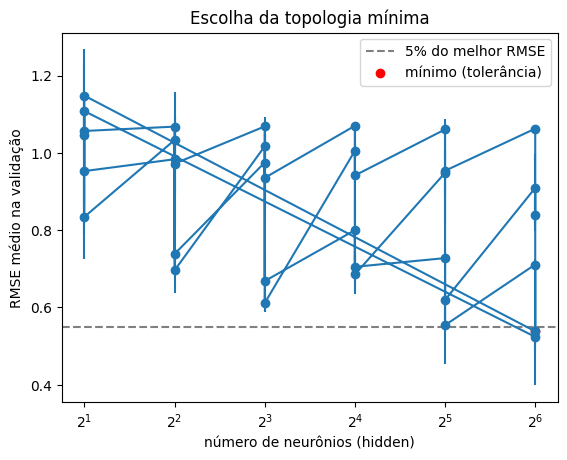

In [ ]:
# =========================
# PLOT RMSE MÉDIO VS HIDDEN
# =========================

hs_list = [r['hidden'] for r in results]
rmse_means = [r['rmse_val_mean'] for r in results]
rmse_stds = [r['rmse_val_std'] for r in results]

plt.figure()
plt.errorbar(hs_list, rmse_means, yerr=rmse_stds, marker='o', linestyle='-')
plt.axhline(best_rmse * 1.05, color='gray', linestyle='--', label='5% do melhor RMSE')
plt.scatter([min_tol_cfg['hidden']], [min_tol_cfg['rmse_val_mean']], color='red', label='mínimo (tolerância)')
plt.xscale('log', base=2)
plt.xlabel('número de neurônios (hidden)')
plt.ylabel('RMSE médio na validação')
plt.legend()
plt.title('Escolha da topologia mínima')
plt.show()

In [ ]:
# =========================
# PLOT RMSE MÉDIO VS HIDDEN
# =========================

with PdfPages("relatorio_final_mlp_keras.pdf") as pdf:
    # Capa
    plt.figure(figsize=(8.27, 11.69))
    plt.axis('off')
    plt.text(0.5, 0.75, "Relatório Final - Experimentos MLP (Keras) \nAluna: Cristiane Gea", ha='center', va='center', fontsize=18)
    pdf.savefig(); plt.close()

    # Páginas por ativação
    for act in activations.keys():
        cfgs = [r for r in results if r['activation']==act]
        fig, axes = plt.subplots(6, 2, figsize=(8.27, 11.69))
        axes = axes.flatten()
        for i, cfg in enumerate(sorted(cfgs, key=lambda x:(x['hidden'], x['epochs']))):
            ax = axes[i]
            preds = cfg['preds_grid']
            mean_pred = preds.mean(axis=0)
            ax.plot(xgrd.ravel(), ymean, label='ymean', color='black')
            ax.plot(xgrd.ravel(), mean_pred, label='pred média', color='blue')
            ax.fill_between(xgrd.ravel(), preds.min(axis=0), preds.max(axis=0), color='blue', alpha=0.2)
            title = f"h={cfg['hidden']}, ep={cfg['epochs']}\nRMSE={cfg['rmse_val_mean']:.3f}±{cfg['rmse_val_std']:.3f}"
            if cfg is best_cfg:
                title = "⭐ " + title
            ax.set_title(title, fontsize=8)
        for j in range(i+1, len(axes)):
            axes[j].axis('off')
        plt.tight_layout()
        pdf.savefig(fig); plt.close(fig)

    # Página de discussão
    plt.figure(figsize=(8.27, 11.69))
    plt.axis('off')
    text = (
        f"A melhor configuração encontrada foi ⭐ {best_cfg['activation']} com "
        f"{best_cfg['hidden']} neurônios e {best_cfg['epochs']} épocas, obtendo "
        f"RMSE médio de validação {best_cfg['rmse_val_mean']:.3f}±{best_cfg['rmse_val_std']:.3f}.\n\n"
        "Redes com poucos neurônios não capturam bem as oscilações. "
        "O aumento do número de neurônios e epochs melhora o erro e a estabilidade. "
        "ReLU mostrou maior consistência, sigmoid maior variabilidade."
    )
    plt.text(0.05, 0.95, text, va='top', fontsize=10, wrap=True)
    pdf.savefig(); plt.close()